# $D_{s1}(2460)^+\to D_s^+\gamma$ production study
## Yields
### MonteCarlo analysis
#### nVeloTracks intervals for MC simulations

Iván Cambón Bouzas

Instituto Galego de Física de Altas Enerxías

Universidade de Santiago de Compostela



In [1]:
import ROOT
from datetime import datetime
import numpy as np
import sys 
import uncertainties as un
import pandas as pd
import matplotlib.pyplot as plt
import os
import mplhep
#ROOT.EnableImplicitMT()
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyFit')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyShort')
import RooPyFit as rpf
import RooPyShort as rsh

print(datetime.now())

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()
mplhep.styles.use(mplhep.styles.LHCb2)

%jsroot

Welcome to JupyROOT 6.28/04
2024-06-20 12:24:41.981892
-------------------------
Set LHCb Style - May 2021
-------------------------


In [2]:
if not os.path.exists("./Graphs"):
    os.makedirs("./Graphs")
else:
    print("Graphs directory already exists")

if not os.path.exists("./root_files"):
    os.makedirs("./root_files")
else:
    print("root_files directory already exists")

Graphs directory already exists
root_files directory already exists


## RDataFrame definition

### MC samples

In [3]:
priv = False
Filt = True

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'
    
dtt = "DsGammaTuple"

tdf_Dsst = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"DsstDsGamma*.root")
tdf_Dsst = tdf_Dsst.Define("DsgM", "Dsg_M-Ds_M+1969")
tdf_Dsst = tdf_Dsst.Define("PVZ_1PV", "PVZ[0]")
tdf_Dsst = tdf_Dsst.Define("Ds_log10_IPCHI2", "log10(Ds_IPCHI2_OWNPV)")

tdf_Ds1 = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"Ds1DsGamma*.root")
tdf_Ds1 = tdf_Ds1.Define("DsgM", "Dsg_M-Ds_M+1969")
tdf_Ds1 = tdf_Ds1.Define("PVZ_1PV", "PVZ[0]")
tdf_Ds1 = tdf_Ds1.Define("Ds_log10_IPCHI2", "log10(Ds_IPCHI2_OWNPV)")

### Control Samples

In [4]:
data_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagDown/2018'

data_files = "DsJ_Data_MagD18_1*.root"         # around 10% of the data sample
dtt = "DsGammaTuple"

tdf_data = ROOT.RDataFrame("{0}/DecayTree".format(dtt), "{0}/{1}".format(data_path, data_files))
tdf_data = tdf_data.Define("DsgM", "Dsg_M-Ds_M+1969")

tdf_data_uhm = tdf_data.Filter("DsgM > 2700")

## TRUEIDs and MCMatching

In [5]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]

TRUEID_Dsst = TRUEID_dtt["DsstDsGamma"]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

tdf_Dsst_sig = tdf_Dsst.Filter(TRUEID_Dsst)
tdf_Ds1_sig = tdf_Ds1.Filter(TRUEID_Ds1)

## Selection and Trigger

In [6]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

off_sel  = "gamma_PT > 1255 && gamma_CL > 0.7 && abs(Ds_M-1969) < 20"
nPVs_req = "nPVs == 1 && nVeloTracks <= 250 && PVZ_1PV < 140 && PVZ_1PV > -40"

L0_cond    = "(Ds_L0HadronDecision_TOS == 1 | Dsg_L0Global_TIS == 1)"
HLT1_cond  = "(Ds_Hlt1TrackMVADecision_TOS == 1 | Ds_Hlt1TwoTrackMVADecision_TOS == 1)"
HLT2_cond  = "(Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS == 1)"
trig_conds = "{0} && {1} && {2}".format(L0_cond, HLT1_cond, HLT2_cond) 

MC_sel = "{0} && {1}".format(off_sel, nPVs_req)

Dsst_window = "DsgM > 2050 && DsgM < 2250"
Ds1_window = "DsgM > 2350 && DsgM < 2600"

tdf_Dsst_sig_sel = tdf_Dsst_sig.Filter("{0} && {1}".format(MC_sel, Dsst_window))
tdf_Ds1_sig_sel  = tdf_Ds1_sig.Filter("{0} && {1}".format(MC_sel, Ds1_window))

tdf_Dsst_sig_sel_trig = tdf_Dsst_sig.Filter("{0} && {1} && {2}".format(MC_sel, Dsst_window, trig_conds))
tdf_Ds1_sig_sel_trig  = tdf_Ds1_sig.Filter("{0} && {1} && {2}".format(MC_sel, Ds1_window, trig_conds))

In [7]:
L0_TIS_cond = "Dsg_L0Global_TIS == 1"

amount = "Run2"
Ds1_model = "CB"
prompt_check = False
TIS = True
    
if TIS:
    L0_trig = "TIS"
    tdf_Dsst_sig_sel_trig = tdf_Dsst_sig_sel_trig.Filter(L0_TIS_cond)
    tdf_Ds1_sig_sel_trig  = tdf_Ds1_sig_sel_trig.Filter(L0_TIS_cond)
else:    
    L0_trig = "TISTOS"
    
if prompt_check:
    tdf_Dsst_sig_sel_trig = tdf_Dsst_sig_sel_trig.Filter("Ds_log10_IPCHI2 < {0}".format(0.4))
    tdf_Ds1_sig_sel_trig = tdf_Ds1_sig_sel_trig.Filter("Ds_log10_IPCHI2 < {0}".format(0.4))
    IP_cut = "tightIP"
else:
    IP_cut = "orIP"

In [8]:
df_Dsst_sig_sel_trig = rsh.rdf_to_pdf(tdf_Dsst_sig_sel_trig, columns=["nVeloTracks"])
df_Ds1_sig_sel_trig  =  rsh.rdf_to_pdf(tdf_Ds1_sig_sel_trig, columns=["nVeloTracks"])

## $\mathrm{N_{Tracks}^{VELO}}$ intervals histogram

In [9]:
inters_path = "./Results"
inters_file = "Exp_Run2_nVeloTracks_binning_CB_TIS_orIP.txt"

nVelo_intervals = np.loadtxt("{0}/{1}".format(inters_path, inters_file))

print(nVelo_intervals)
ninters = len(nVelo_intervals) - 1

[  8.  60.  78.  95. 115. 248.]


In [10]:
hist_nVelo_Dsst_sig_sel_trig, bins_nVelo_Dsst_sig_sel_trig = np.histogram(df_Dsst_sig_sel_trig["nVeloTracks"], bins=nVelo_intervals)

hist_nVelo_Ds1_sig_sel_trig, bins_nVelo_Ds1_sig_sel_trig = np.histogram(df_Ds1_sig_sel_trig["nVeloTracks"], bins=nVelo_intervals)

plt.figure(1)
mplhep.histplot((hist_nVelo_Dsst_sig_sel_trig, bins_nVelo_Dsst_sig_sel_trig), 
                color="red", yerr=True, histtype="errorbar", xerr=True, label=r"$D_s^{*+}$")
mplhep.histplot((hist_nVelo_Ds1_sig_sel_trig, bins_nVelo_Ds1_sig_sel_trig), 
                color="blue", yerr=True, histtype="errorbar", xerr=True, label=r"$D_{s1}^+$")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel("#")
plt.title("MC events after all selection procedure")
plt.legend()
plt.savefig("Graphs/Sim_DsgL_nVelo_hist_{0}_{1}Velo_{2}_{3}.pdf".format(Ds1_model, ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')

In [11]:
Ngen_Dsst = 9891119626; uNgen_Dsst = 0
Ngen_Ds1 = 11916691071; uNgen_Ds1 = 0

eff_tot_Dsst = hist_nVelo_Dsst_sig_sel_trig / Ngen_Dsst
ueff_tot_Dsst = np.sqrt(eff_tot_Dsst * (1 - eff_tot_Dsst)/Ngen_Dsst)

eff_tot_Ds1 = hist_nVelo_Ds1_sig_sel_trig / Ngen_Ds1
ueff_tot_Ds1 = np.sqrt(eff_tot_Ds1 * (1 - eff_tot_Ds1)/Ngen_Ds1)

plt.figure(1)
mplhep.histplot((eff_tot_Dsst, bins_nVelo_Dsst_sig_sel_trig), 
                color="red", histtype="errorbar", yerr=ueff_tot_Dsst, xerr=True, label=r"$D_s^{*+}$")
mplhep.histplot((eff_tot_Ds1, bins_nVelo_Ds1_sig_sel_trig), 
                color="blue", histtype="errorbar", yerr=ueff_tot_Ds1, xerr=True, label=r"$D_{s1}^+$")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{T}$")
plt.title("MC Total efficiency")
plt.legend()
plt.savefig("Graphs/Sim_DsgL_tot_effs_{0}_{1}Velo_{2}_{3}.pdf".format(Ds1_model, ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')

[0.05879426 0.05703348 0.05147654 0.06120636 0.06924835]
[0.00319122 0.00329389 0.00324746 0.00382544 0.00496148]


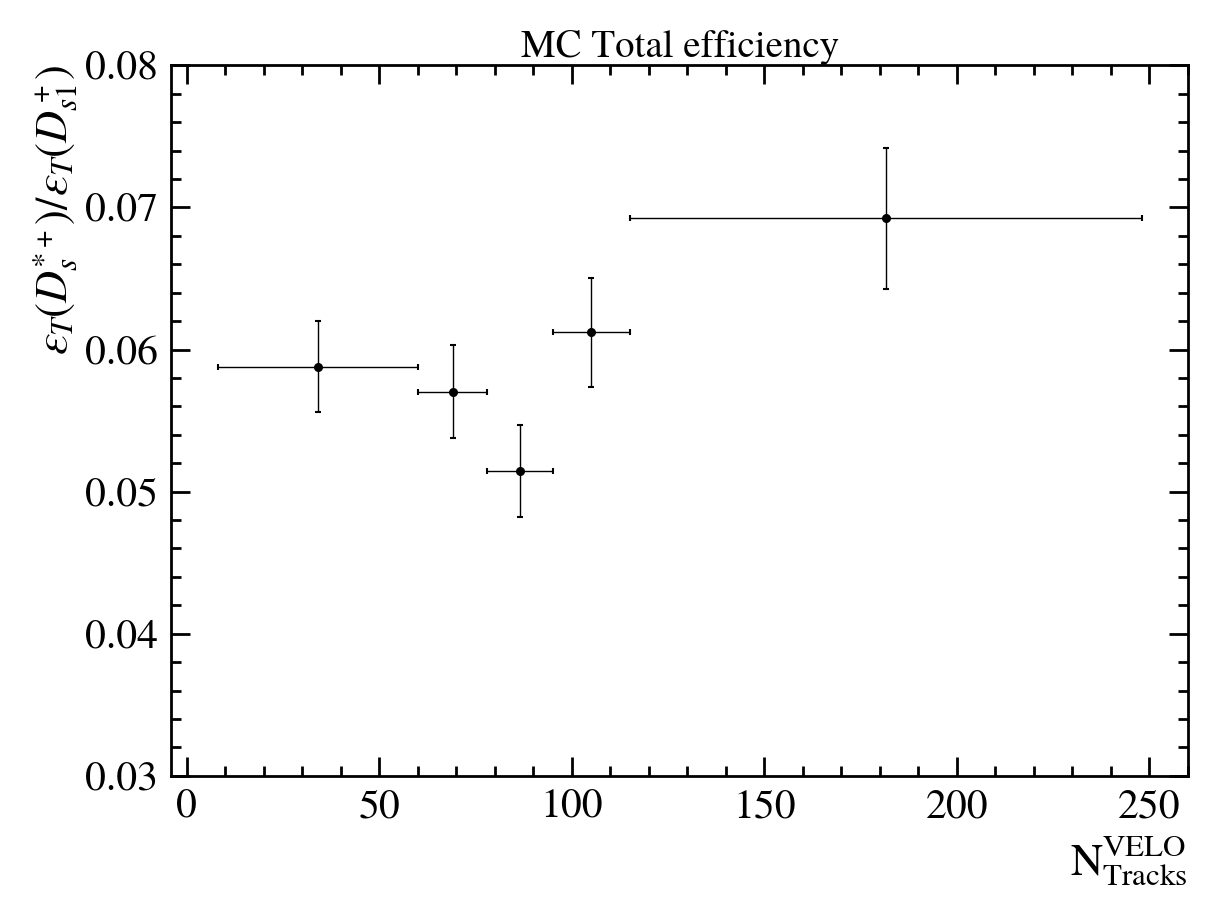

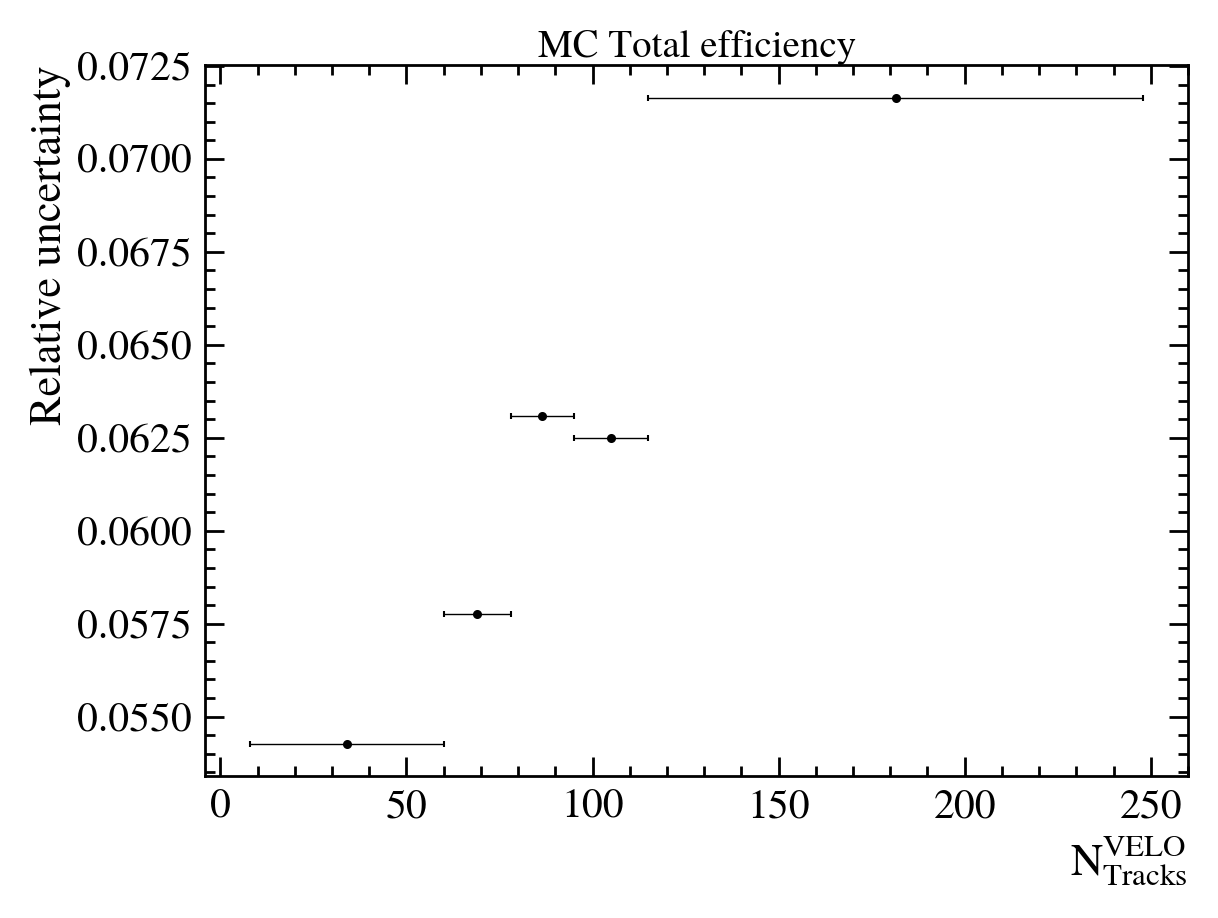

In [12]:
ratio_eff_tot = eff_tot_Dsst / eff_tot_Ds1
uratio_eff_tot = ratio_eff_tot * np.sqrt((ueff_tot_Dsst/eff_tot_Dsst)**2 + (ueff_tot_Ds1/eff_tot_Ds1)**2)

print(ratio_eff_tot)
print(uratio_eff_tot)

plt.figure(1)
mplhep.histplot((ratio_eff_tot, bins_nVelo_Dsst_sig_sel_trig), color="black", histtype="errorbar", yerr=uratio_eff_tot, xerr=True)
plt.ylim(0.03, 0.08)
plt.title("MC Total efficiency ratio")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"$\varepsilon_{T}(D_s^{*+})/\varepsilon_{T}(D_{s1}^+)$")
plt.title("MC Total efficiency")
plt.savefig("Graphs/Sim_DsgL_tot_effs_ratio_{0}_{1}Velo_{2}_{3}.pdf".format(Ds1_model, ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')

plt.figure(2)
mplhep.histplot((uratio_eff_tot/ratio_eff_tot, bins_nVelo_Dsst_sig_sel_trig), color="black", histtype="errorbar", yerr=False, xerr=True)
plt.title("MC Total efficiency ratio")
plt.xlabel(r"$\mathrm{N}^{\mathrm{VELO}}_{\mathrm{Tracks}}$")
plt.ylabel(r"Relative uncertainty")
plt.title("MC Total efficiency")
plt.savefig("Graphs/Sim_DsgL_tot_effs_ratio_ru_{0}_{1}Velo_{2}_{3}.pdf".format(Ds1_model, ninters, L0_trig, IP_cut), dpi=300, bbox_inches='tight')

np.savetxt("Results/MC_DsgL_eff_tot_ratio_vals_{0}_{1}_{2}.txt".format(Ds1_model, L0_trig, IP_cut), ratio_eff_tot)
np.savetxt("Results/MC_DsgL_eff_tot_ratio_uncs_{0}_{1}_{2}.txt".format(Ds1_model, L0_trig, IP_cut), uratio_eff_tot)